# Some Interesting CNN formulations

Attempted several different methods of structuring input to the CNN - including Fourier Transforming the signal, etc. 

In [1]:
# Imports and setup

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM
from keras.layers import GRU
import matplotlib.pyplot as plt

from utils.load_data import *
from utils.utilities import *
from models.cnn import CNN
from models.rnn import RNN
from models.fft_cnn import FFT_CNN_1, FFT_CNN_2, FFT_FCNET
from models.autoencoder import Autoencoder
#from models.VAE import *


%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Load Data

In [2]:
# Loads data from the EEG dataset and removes all EOG data

person_train_val, X_train_val, y_train_val, person_test, X_test, y_test = load_EEG_data()

print ('Training/Valid data shape: {}'.format(X_train_val.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_val.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_val.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


## Split into train and validation datasets

In [3]:
X_train, y_train, X_val, y_val = split_train_val(X_train_val, y_train_val, percent_validation=0.1)

print ('Training data shape: {}'.format(X_train.shape))
print ('Training target shape: {}'.format(y_train.shape))
print ('Validation data shape: {}'.format(X_val.shape))
print ('Validation target shape: {}'.format(y_val.shape))

Training data shape: (1904, 22, 1000)
Training target shape: (1904,)
Validation data shape: (211, 22, 1000)
Validation target shape: (211,)


## One hot encoding for all labels

In [4]:
print (y_val[33])
print (y_val.shape)
print (y_test.shape)

y_train_labels = one_hot_encode(y_train)
y_val_labels = one_hot_encode(y_val)
y_test_labels = one_hot_encode(y_test)

print (y_val_labels[33])
print (y_val_labels.shape)
print (y_test_labels.shape)

772
(211,)
(443,)
[0. 0. 0. 1.]
(211, 4)
(443, 4)


## Visualizing Data under FFT 

/Users/HirdayGupta/Documents/UCLA/Winter_19/ECE_239AS/Homeworks/neural_nets/env/lib/python3.6/site-packages/matplotlib/transforms.py:827: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


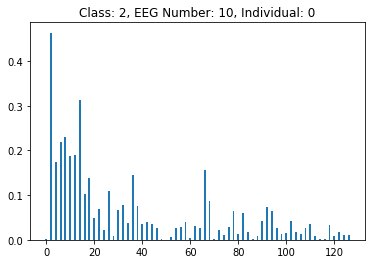

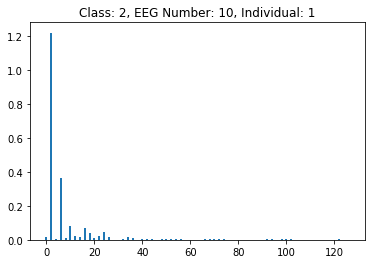

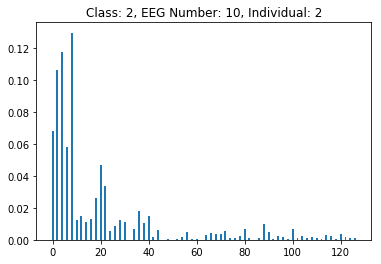

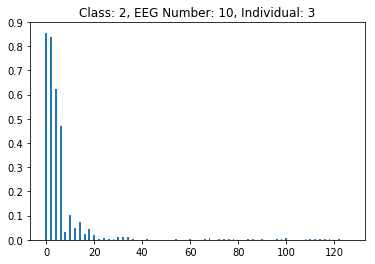

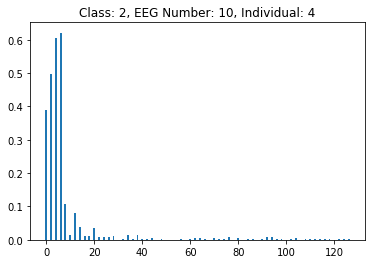

In [5]:
class1_idx = np.argwhere(y_train==769).flatten()
class2_idx = np.argwhere(y_train==770).flatten()
class3_idx = np.argwhere(y_train==771).flatten()
class4_idx = np.argwhere(y_train==772).flatten()

class_idxs = [class1_idx, class2_idx, class3_idx, class4_idx]

EEG_NUM = 10 # 0-21
CLASS_NUM = 2 # 0,1,2,3

for i in np.arange(5):
    EEG_trial = X_train[class_idxs[CLASS_NUM][i],EEG_NUM,:]
    EEG_trial_fft, freqs = fft_electrode_data(EEG_trial)
    plt.bar(freqs, EEG_trial_fft)
    plt.title("Class: {}, EEG Number: {}, Individual: {}".format(CLASS_NUM, EEG_NUM, i))
    plt.show()

## Handcrafting features for CNN using FFT and Evaluating Performance

In [6]:
X_train_fft, X_val_fft, X_test_fft = fft_and_reshape(X_train), fft_and_reshape(X_val), fft_and_reshape(X_test)

print (X_train_fft.shape)
print (X_val_fft.shape)
print (X_test_fft.shape)

# Note: Went from 1000 timesteps to 64 power densities for 64 frequencies (between 0 & 128)

/Users/HirdayGupta/Documents/UCLA/Winter_19/ECE_239AS/Homeworks/neural_nets/utils/utilities.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fft[i][j] = EEG_trial_FFT


(1904, 64, 22)
(211, 64, 22)
(443, 64, 22)


In [ ]:
cnn = FFT_CNN_1(X_train_fft, y_train_labels, X_val_fft, y_val_labels, X_test_fft, y_test_labels, dropout=0.25)
cnn.train(stride=1, optimizer='adam', epochs=50)
test_loss, test_accuracy = cnn.evaluate()

#cnn.show_model()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

In [ ]:
cnn = FFT_CNN_1(X_train_fft, y_train_labels, X_val_fft, y_val_labels, X_test_fft, y_test_labels, dropout=0.3, use_elu=True)
cnn.train(stride=1, optimizer='adam', epochs=50)
test_loss, test_accuracy = cnn.evaluate()

#cnn.show_model()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

In [ ]:
cnn = FFT_CNN_1(X_train_fft, y_train_labels, X_val_fft, y_val_labels, X_test_fft, y_test_labels, dropout=0.7, use_elu=True, use_batchnorm=True)
cnn.train(stride=1, optimizer='adam', epochs=10)
test_loss, test_accuracy = cnn.evaluate()

#cnn.show_model()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

### Reshape FFT data 
Shaped data into a 5x5x64 grid formulation - in an attemp to preserve the spatial locality of the electrodes, using the 64 PSD values associated with 64 frequencies (the output of the FFT) as channels

In [7]:
X_train_fft_sp = reshape_fft_spatial(X_train_fft)
X_val_fft_sp = reshape_fft_spatial(X_val_fft)
X_test_fft_sp = reshape_fft_spatial(X_test_fft)

print (X_train_fft_sp.shape)
print (X_val_fft_sp.shape)
print (X_test_fft_sp.shape)

(1904, 5, 5, 64)
(211, 5, 5, 64)
(443, 5, 5, 64)


In [ ]:
cnn = FFT_CNN_2(X_train_fft_sp, y_train_labels, X_val_fft_sp, y_val_labels, X_test_fft_sp, y_test_labels, dropout=0.35, use_batchnorm=True)
cnn.train(stride=1, optimizer='adam', epochs=30)
test_loss, test_accuracy = cnn.evaluate()

#cnn.show_model()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

### Reshape for FCNet

In [8]:
X_train_fft_1d = reshape_fft_1D(X_train_fft)
X_val_fft_1d = reshape_fft_1D(X_val_fft)
X_test_fft_1d = reshape_fft_1D(X_test_fft)

print (X_train_fft_1d.shape)
print (X_val_fft_1d.shape)
print (X_test_fft_1d.shape)

(1904, 1408)
(211, 1408)
(443, 1408)


In [ ]:
fcnet = FFT_FCNET(X_train_fft_1d, y_train_labels, X_val_fft_1d, y_val_labels, X_test_fft_1d, y_test_labels, use_batchnorm=True, dropout=0.3)
fcnet.train(optimizer='adam', epochs=50)
test_loss, test_accuracy = fcnet.evaluate()

#cnn.show_model()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)